# Table of Contents
 <p><div class="lev2"><a href="#ベイジアンネットワーク"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>ベイジアンネットワーク</a></div><div class="lev2"><a href="#遺伝子発現解析での使い方"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>遺伝子発現解析での使い方</a></div><div class="lev3"><a href="#3遺伝子の例"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>3遺伝子の例</a></div><div class="lev2"><a href="#ノンパラメトリックベイジアンネットワーク"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>ノンパラメトリックベイジアンネットワーク</a></div><div class="lev2"><a href="#実装"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>実装</a></div><div class="lev2"><a href="#参考文献"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>参考文献</a></div>

## ベイジアンネットワーク
条件付き確率で表されたネットワークのうち、ループ構造がないもの

* A:雨がふった
* B:スプリンクラーが動いた
* C: 芝生が濡れた

の3つの関係の適切なモデルを求める。

芝生が濡れたから雨が降った(C->A)のか、雨が降ったから芝生が濡れた(A->C)のか、どちらなのかを知るには、スプリンクラーが動いたときに雨が降ることに影響する(B->C->A)かどうかを調べれば分かる。

つまり、すべてのパターンを調べれば、どのモデルが適切か分かる。

## 遺伝子発現解析での使い方
1. 大量の遺伝子発現解析データから求められている同時確率分布$P(G_{1}, \cdots G_{N})$を用いて
2. 遺伝子$G_{1}, \cdots G_{N}$の間の統計的依存関係を見出し
3. 非循環型の有効グラフでネットワーク構造を表現

親遺伝子を$\pi(G)$とすると、ベイジアンネットワークによる遺伝子ネットワークの表現は、同時確率分布を条件付き確率の積として展開することと同等。

$P(G_{1}, \cdots G_{N})=\Pi_{i} P(G_{i} | \pi (G_{i}))$

### 3遺伝子の例
考えられるモデルは25個。ここから最も確からしいモデルを選択する。評価関数は、データDが与えられたときネットワーク構造$N_{i}$が実現する事後確率$P(N_{i}|D)$を評価関数に用いる。

事後確率は、ベイズの定理から

$P(N_{i}|D)=\frac{P(D|N_{i})P(N_{i})}{P(D)}$



## ノンパラメトリックベイジアンネットワーク

see [here](http://www.uv.es/bernardo/Ickstadt.pdf)



## 確率


参考 : https://bugra.github.io/work/notes/2014-05-23/simple-bayesian-network-via-monte-carlo-markov-chain-mcmc-pymc/

のpymc3 バージョン: https://stackoverflow.com/questions/42470592/simple-bayesian-network-via-monte-carlo-markov-chain-ported-to-pymc3

In [3]:
import daft
import pymc3
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import ggplot
import pandas as pd

COLORS = ["#348ABD", "#A60628", "#7A68A6"]

daft : 確率モデルのプロットをするライブラリ

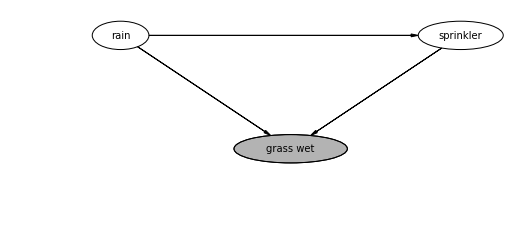

In [5]:
pgm = daft.PGM([9, 4], origin=[1, 0.5])
pgm.add_node(daft.Node('r', 'rain', 3, 4, aspect=2))
pgm.add_node(daft.Node('s', 'sprinkler', 9, 4, aspect=3))
pgm.add_node(daft.Node('w', 'grass wet', 6, 2, aspect=4, observed=True))
pgm.add_edge('r', 's')
pgm.add_edge('r', 'w')
pgm.add_edge('s', 'w')
pgm.render()

In [9]:
from IPython.display import Image
Image(url='./SimpleBayesNet.svg')

In [52]:
import numpy as np
import pandas as pd
import pymc3 as pm

niter = 10000  # 10000
tune = 5000  # 5000

model = pm.Model()

with model:
    tv = [1]
    rain = pm.Bernoulli('rain', 0.2, shape=1, testval=tv)
    sprinkler_p = pm.Deterministic('sprinkler_p', pm.math.switch(rain, 0.01, 0.40))
    sprinkler = pm.Bernoulli('sprinkler', sprinkler_p, shape=1, testval=tv)
    grass_wet_p = pm.Deterministic('grass_wet_p', pm.math.switch(rain, pm.math.switch(sprinkler, 0.99, 0.80), pm.math.switch(sprinkler, 0.90, 0.0)))
    # これが含まれるとrainの確率が変わる 0.2→0.34
    # わざとobservedが毎回grass_wet == 1として与えている
    # 濡れていたときに雨がふった確率を求めたいから
    grass_wet = pm.Bernoulli('grass_wet', grass_wet_p, observed=np.array([1]), shape=1)
    # BinaryGibbsMetropolis
    # 第一引数 : List of variables for sampler
    # tune : boolなのに数値を与えているのもおかしい
    trace = pm.sample(5000, step=[pm.BinaryGibbsMetropolis([rain, sprinkler])], tune=tune, random_seed=124)
    # ふつうにサンプリングすればいいだけでは？ BinaryGibbsMetropolisでも変わらない
#     trace = pm.sample(10000, random_seed=124)

/Users/kazumasa/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/pymc3/sampling.py:231: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically '
/Users/kazumasa/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/pymc3/sampling.py:234: UserWarning: Automatic initialization is not supported for discrete variables. Ignoring init argument.
  warnings.warn('Automatic initialization is not supported '
100%|██████████| 5000/5000 [00:01<00:00, 3638.41it/s]


たくさんサンプリングできるのであれば、条件付き確率は、

$P(R|W)=\frac{P(R,W)}{P(W)}$

で求まる。たしかに。

In [53]:
# pm.traceplot(trace)

dictionary = {
              'Rain': [1 if ii[0] else 0 for ii in trace['rain'].tolist() ],
              'Sprinkler': [1 if ii[0] else 0 for ii in trace['sprinkler'].tolist() ],
              'Sprinkler Probability': [ii[0] for ii in trace['sprinkler_p'].tolist()],
              'Grass Wet Probability': [ii[0] for ii in trace['grass_wet_p'].tolist()],
              }
df = pd.DataFrame(dictionary)

p_rain = df[(df['Rain'] == 1)].shape[0] / df.shape[0]
print(p_rain)

p_sprinkler = df[(df['Sprinkler'] == 1)].shape[0] / df.shape[0]
print(p_sprinkler)

0.3664
0.6388


## 参考文献
* [ベイジアンネットワークを用いた遺伝子ネットワークの
推定と解析](http://www.scls.riken.jp/wp-content/uploads/2014/06/SiGN-BN0318.pdf)